In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import zipfile

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"


--2021-05-19 07:14:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 172.217.7.240, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   135MB/s    in 1.2s    

2021-05-19 07:14:59 (135 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
zip = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip.extractall()
zip.close()

In [4]:
import os

for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/10_food_classes_10_percent
There are 10 directories and 0 images in /content/10_food_classes_10_percent/test
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/sushi
There are 0

In [5]:
#Preparing the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE= (224,224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train" 
test_dir = "/content/10_food_classes_10_percent/test"

train_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

traindata = train_gen.flow_from_directory(train_dir,
                                          batch_size = BATCH_SIZE,
                                          target_size =IMAGE_SHAPE,
                                          class_mode = 'categorical')

testdata = test_gen.flow_from_directory(test_dir,
                                          batch_size = BATCH_SIZE,
                                          target_size =IMAGE_SHAPE,
                                          class_mode = 'categorical')


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [6]:
#Settingup callbacks
import datetime

def create_tensorboard_callback(dirname,experiment_name):
  log_dir = dirname + "/" + experiment_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print("Saving Tensorboard logfiles")
  return tensorboard_callback




In [7]:
#Building transferlearning model

import tensorflow_hub as hub

model_eff = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False,input_shape = IMAGE_SHAPE+(3,)),
        tf.keras.layers.Dense(10, activation='softmax')                     
])

model_res = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
                   trainable=False,input_shape = IMAGE_SHAPE+(3,)),
        tf.keras.layers.Dense(10, activation='softmax')                     
])

In [8]:
model_eff.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [9]:
model_eff.compile(loss='categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [10]:
model_res.compile(loss='categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [11]:
history_eff = model_eff.fit(traindata,
                          epochs=5,
                          steps_per_epoch = len(traindata),
                          validation_data=testdata,
                          validation_steps = len(testdata),
                          callbacks=[create_tensorboard_callback(dirname='tensorflow_hub',experiment_name='effnet')])

Saving Tensorboard logfiles
Epoch 1/5
24/24 [==============================] - 57s 788ms/step - loss: 2.1537 - accuracy: 0.2217 - val_loss: 1.3370 - val_accuracy: 0.7232
Epoch 2/5
24/24 [==============================] - 15s 625ms/step - loss: 1.1410 - accuracy: 0.7713 - val_loss: 0.8748 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 14s 620ms/step - loss: 0.8186 - accuracy: 0.8393 - val_loss: 0.7026 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 14s 622ms/step - loss: 0.6378 - accuracy: 0.8604 - val_loss: 0.6171 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 14s 622ms/step - loss: 0.5039 - accuracy: 0.8982 - val_loss: 0.5659 - val_accuracy: 0.8568


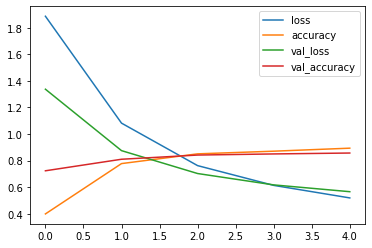

In [13]:
pd.DataFrame(history_eff.history).plot()

In [14]:
history_res = model_res.fit(traindata,
                          epochs=5,
                          steps_per_epoch = len(traindata),
                          validation_data=testdata,
                          validation_steps = len(testdata),
                          callbacks=[create_tensorboard_callback(dirname='tensorflow_hub',experiment_name='resnet')])

Saving Tensorboard logfiles
Epoch 1/5
24/24 [==============================] - 22s 789ms/step - loss: 2.5547 - accuracy: 0.1555 - val_loss: 1.2700 - val_accuracy: 0.5932
Epoch 2/5
24/24 [==============================] - 15s 665ms/step - loss: 1.0394 - accuracy: 0.6812 - val_loss: 0.8693 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 15s 664ms/step - loss: 0.6846 - accuracy: 0.8082 - val_loss: 0.7526 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 15s 663ms/step - loss: 0.5033 - accuracy: 0.8663 - val_loss: 0.7001 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 16s 665ms/step - loss: 0.4119 - accuracy: 0.9120 - val_loss: 0.6844 - val_accuracy: 0.7800


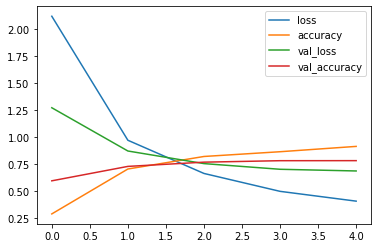

In [15]:
pd.DataFrame(history_res.history).plot()

In [17]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNet vs Resnet" \
  --one_shot

2021-05-19 07:45:54.151070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [18]:
!tensorboard dev list

2021-05-19 07:51:42.573216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/7oyk4Yg4ROyf8p6ej7vObg/
	Name                 [No Name]
	Description          [No Description]
	Id                   7oyk4Yg4ROyf8p6ej7vObg
	Created              2021-05-19 07:46:38 (5 minutes ago)
	Updated              2021-05-19 07:46:40 (5 minutes ago)
	Runs                 4
	Tags                 3
	Scalars              40
	Tensor bytes         0
	Binary object bytes  5858571
Total: 1 experiment(s)
